In [ ]:
%run ML_funcs.py

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
#import all necessary packages
import re
import os
import random
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [23]:
#import all images and partition into training, validation, and testing
directory = './Garbage classification/Garbage classification/'

#training
train_file = './one-indexed-files-notrash_train.txt'
df_train = pd.read_csv(train_file, sep=' ', header=None, names=['rel_path', 'label'])
df_train = add_class_name_prefix(df_train, 'rel_path')
df_train['label'] = df_train['label'].apply(class_id_to_label)

#validation
val_file   = './one-indexed-files-notrash_val.txt'
df_valid = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_valid = add_class_name_prefix(df_valid, 'rel_path')
df_valid['label'] = df_valid['label'].apply(class_id_to_label)

#testing
test_file  = './one-indexed-files-notrash_test.txt'
df_test  = pd.read_csv(val_file,   sep=' ', header=None, names=['rel_path', 'label'])
df_test  = add_class_name_prefix(df_test,  'rel_path')
df_test['label - mapped']  = df_test['label'].apply(class_id_to_label)

print(f'Found {len(df_train)} training, {len(df_valid)} validation and {len(df_test)} samples.')

Found 1768 training, 328 validation and 328 samples.


In [25]:
df_test.head(5)

,rel_path,label,label - mapped
0,cardboard/cardboard114.jpg,3,cardboard
1,plastic/plastic204.jpg,4,plastic
2,glass/glass123.jpg,1,glass
3,glass/glass152.jpg,1,glass
4,glass/glass398.jpg,1,glass


(0.0, 650.0)

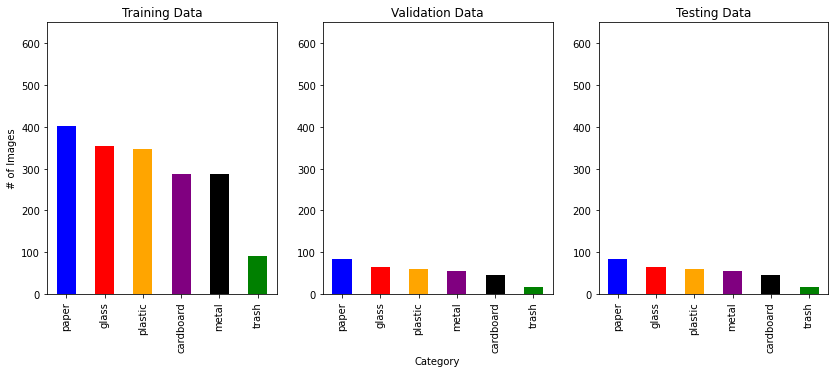

In [4]:
#visualize the distribution of images
fig,axs = plt.subplots(ncols=3, figsize=(14,5))
df_train['label'].value_counts().plot.bar(color = ['blue', 'red', 'orange', 'purple', 'black', 'green'], ax=axs[0])
axs[0].set_title('Training Data')
axs[0].set_ylabel('# of Images')
axs[0].set_ylim(0, 650)
df_valid['label'].value_counts().plot.bar(color = ['blue', 'red', 'orange', 'purple', 'black', 'green'], ax=axs[1])
axs[1].set_title('Validation Data')
axs[1].set_xlabel('Category')
axs[1].set_ylim(0, 650)
df_test['label'].value_counts().plot.bar(color = ['blue', 'red', 'orange', 'purple', 'black', 'green'], ax=axs[2])
axs[2].set_title('Testing Data')
axs[2].set_ylim(0, 650)

./Garbage classification/Garbage classification/glass/glass157.jpg


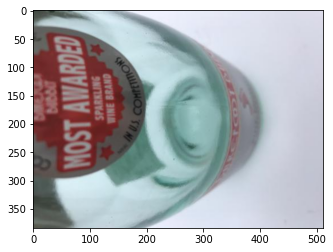

In [5]:
#load an image just to view the samples
sample = random.choice(directory+df_train['rel_path'])
image = load_img(sample)
plt.imshow(image)
print(sample)

In [6]:
#augment image data with keras imagedatagenerator

datagen = ImageDataGenerator()

#augmenting training data
datagen_train = datagen.flow_from_dataframe(
    dataframe=df_train,directory=directory,
    x_col='rel_path', y_col='label',
    color_mode="rgb", class_mode="categorical",
    batch_size=32, shuffle=True,
    seed=7)

#augmenting validation data
datagen_valid = datagen.flow_from_dataframe(
    dataframe=df_valid, directory=directory,
    x_col='rel_path', y_col='label',
    color_mode="rgb", class_mode="categorical",
    batch_size=32,shuffle=True,
    seed=7)

Found 1768 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.


Learning rate is from 0.0005 to 0.0002869244063120796


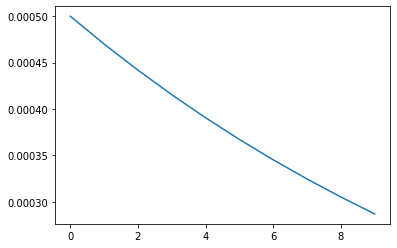

In [7]:
# Defining Callback Params (Learning Rate & Early Stopping)

#Early Stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


#Learning Rate
i=0
epochs=10
start_lr= 5e-4
minimum_lr = 1e-6
exp_lr = .94
def lrfn(epoch):
    lr = (start_lr - minimum_lr) * exp_lr**(epoch+i) + minimum_lr
    return lr
lr_callback = LearningRateScheduler(lrfn, verbose=True)

#view learning rate
rng = [i for i in range(i,epochs+i)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print('Learning rate is from '+str(y[0])+' to '+str(y[-1]))


## Model

In [11]:
#model is defined in function file that is called in line 1
#num classes is 6 becasuse we have 6 categories of waste
net = build_model(num_classes=6)
net.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.categorical_accuracy])
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

## Training

In [ ]:
#train the model
history = net.fit_generator(generator=datagen_train, validation_data=datagen_valid, epochs=epochs,
    validation_freq=1, callbacks=[early_stop, lr_callback])

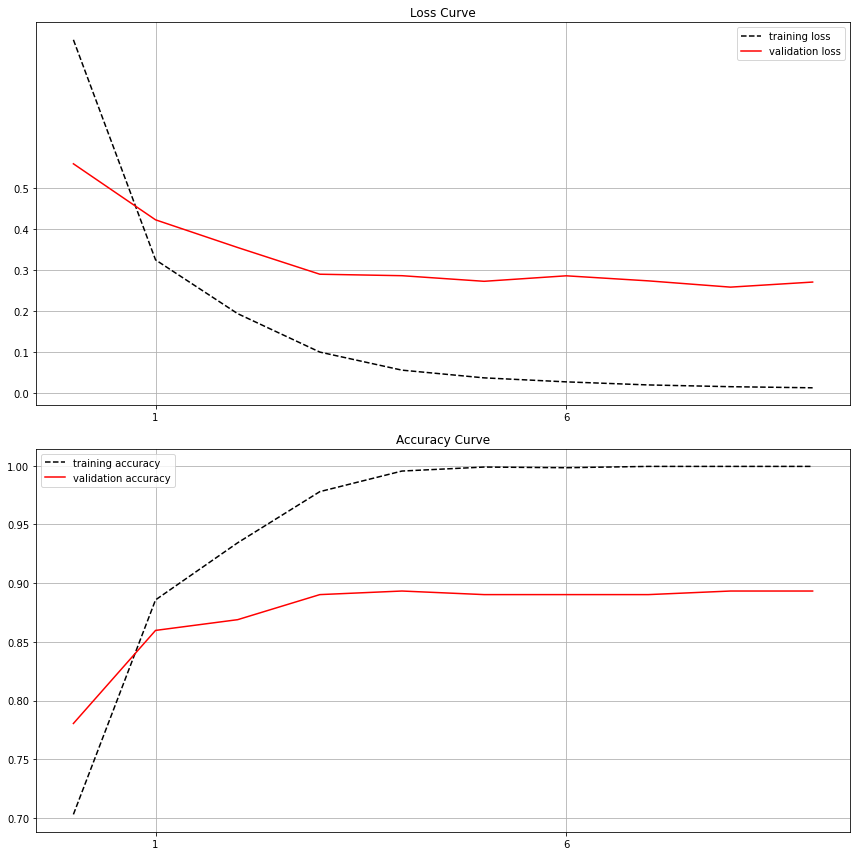

In [13]:
# Visualize the training process by graphing the loss curves and accuracy curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'],c="black",label="training loss",linestyle='dashed')
ax1.plot(history.history['val_loss'], c='r', label="validation loss")
ax1.legend()
ax1.grid()
ax1.set_xticks(np.arange(1, len(history.history["loss"]), 5))
ax1.set_yticks(np.arange(0, max(history.history['val_loss']), round(max(history.history['val_loss'])/9, 1)))
ax1.set_title('Loss Curve')

ax2.plot(history.history['categorical_accuracy'], color='black', label="training accuracy",linestyle='dashed')
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="validation accuracy")
ax2.legend()
ax2.grid()
ax2.set_xticks(np.arange(1, len(history.history["loss"]), 5))
ax2.set_yticks(np.arange(0.7, 1, 0.05))
ax2.set_title('Accuracy Curve')
plt.tight_layout()
plt.show()

In [14]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=directory,
    x_col='rel_path',
    y_col='label',
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    seed=7
)

# y_pred = net.predict(test_generator, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

net.evaluate_generator(test_generator, nb_samples)

Found 328 validated image filenames belonging to 6 classes.


C:\Users\lelia\AppData\Local\Temp\ipykernel_22972\2480221547.py:18: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  net.evaluate_generator(test_generator, nb_samples)


[0.27047914266586304, 0.8932926654815674]

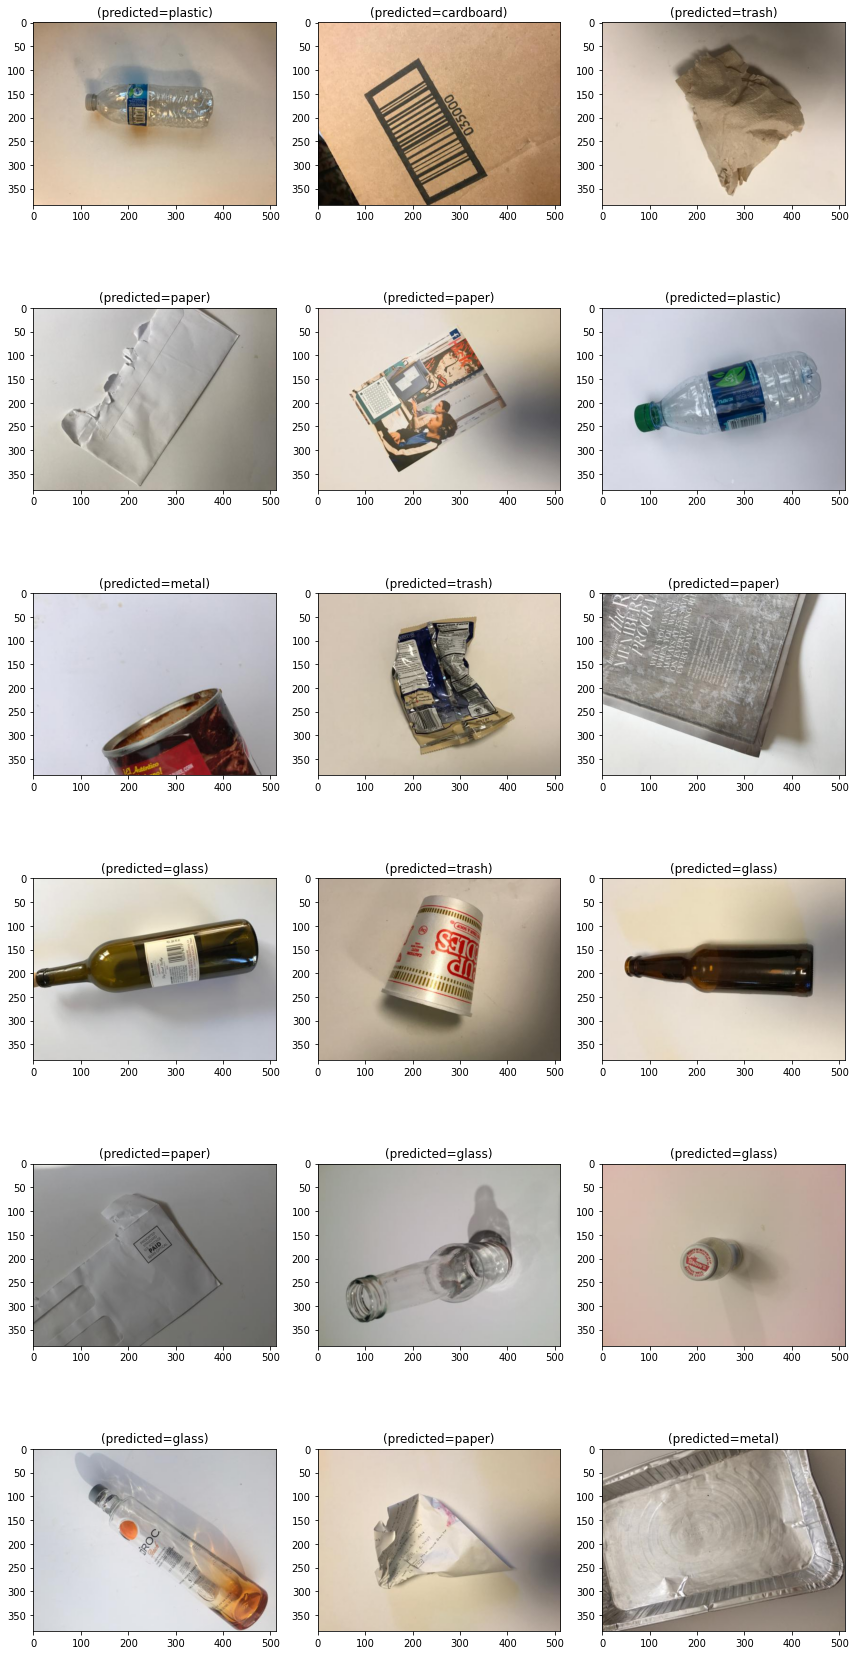

In [15]:
sample_test = df_test.sample(n=18)
plt.figure(figsize=(12, 24))

i=1
for index, row in sample_test.iterrows():
    if i <= 18:
        filename = directory + row['rel_path']
        category = row['label']
        img = load_img(filename)
        plt.subplot(6, 3, i)
        plt.imshow(img)
        plt.title('(predicted=' + "{}".format(category) + ')')
        i+=1
plt.tight_layout()

plt.show()
